
# Modelamiento e identificación del UNDCMotor

El UNDCMotor es un minilaboratorio que permite el control de velocidad y posición de un motor DC para ilustrar los principios básicos del control autómatico.


## 1. Configuración


### Instalación de la libreria unmotor

Solo ejecutarla para instalar por primera vez, descomentando la linea siguiente. __Asegúrese de instalar  [Git](https://git-scm.com/download/win/ "Git").__

In [ ]:
# import subprocess
# command = ["pip", "install", "-I", "--user" "git+https://github.com/nebisman/UNDCMotor.git@main#subdirectory=code/python_code"]
# process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
# for line in process.stdout:
#     print(line.strip())


### Importación de comandos de la libreria unmotor y de Matplotlib 

A continuación importamos los comandos básicos que usaremos de la libreria unmotor y la libreria Matplotlib para realizar trabajo adicional con las figuras. 

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import unmotor as mot


---


## 2. Definición del sistema en el IoT

Lo primero que necesitamos es definir el sistema y su conexión al IoT. Esto lo hacemos mediante el  comando

`MotorSystemIoT(plant_number="xxxx", broker_address = "xx.xxx.xxx.xxx")`.

+ El parámetro `plant_number` es el identificador de la planta con que está trabajando. Por ejemplo `plant_number= "PC-T-XX"`

+ El parámetro `broker_address` es la dirección IP del broker al cual se conecta la planta. Por ejemplo ` broker_address = "192.168.1.100"` 

In [6]:
my_motor = mot.MotorSystemIoT(plant_number = "MOTOR_LEO", broker_address = "192.168.0.9", port=8883) 


## 3. Modelo estático del UNDCMotor

Es natural comenzar investigando el comportamiento estacionario de un sistema bajo
control. Esto se hace mediante una curva que muestra el valor en estado estacionario de la
salida (en este caso, la velocidad del motor DC) para diferentes valores de la variable de
entrada (en este caso la tensión aplicada). A esta curva se le denomina Modelo Estático del
Sistema.


El modelo estático se puede obtener experimentalmente de varias formas. *Una manera
habitual es ajustar un valor constante de entrada y medir la salida en estado estacionario.
Esto da un punto del modelo estático. Este procedimiento se repite para cubrir el
rango completo de entradas.*

+ La  función `get_static_model(system)` nos permite obtener el modelo estático del UNDCmotor definido por la instancia del UNDCMotor creada con la función  `MotorSystemIoT(.)`
+ La función `plt.savefig(.)` permite guardar la figura en en cualquier formato para su video informe.

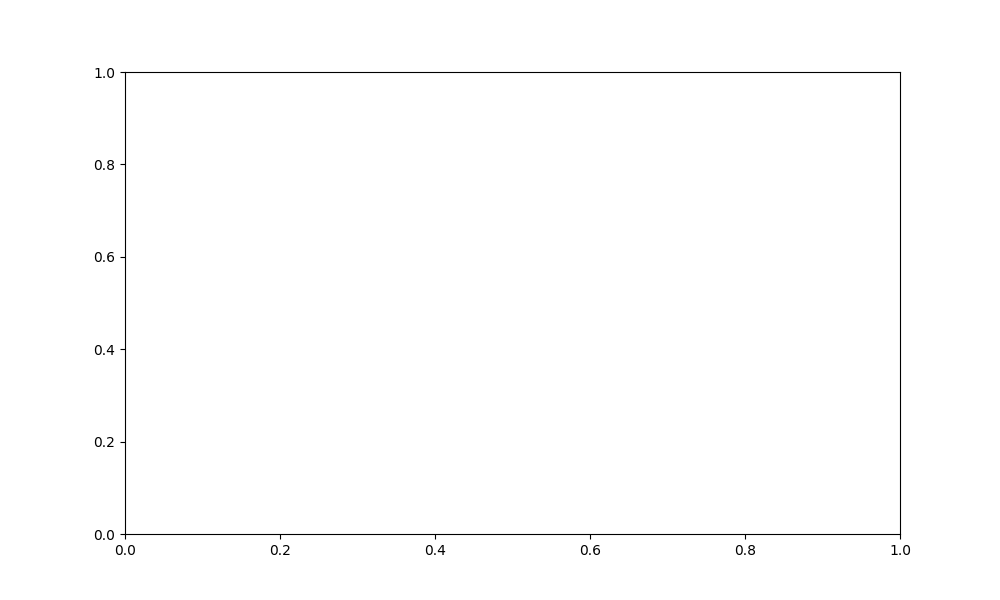

Connected successfully to MQTT Broker!
Subscribed:  1   (2,)
Connected successfully to MQTT Broker!
Subscribed:  22   (2,)
Static model esperiment has been completed


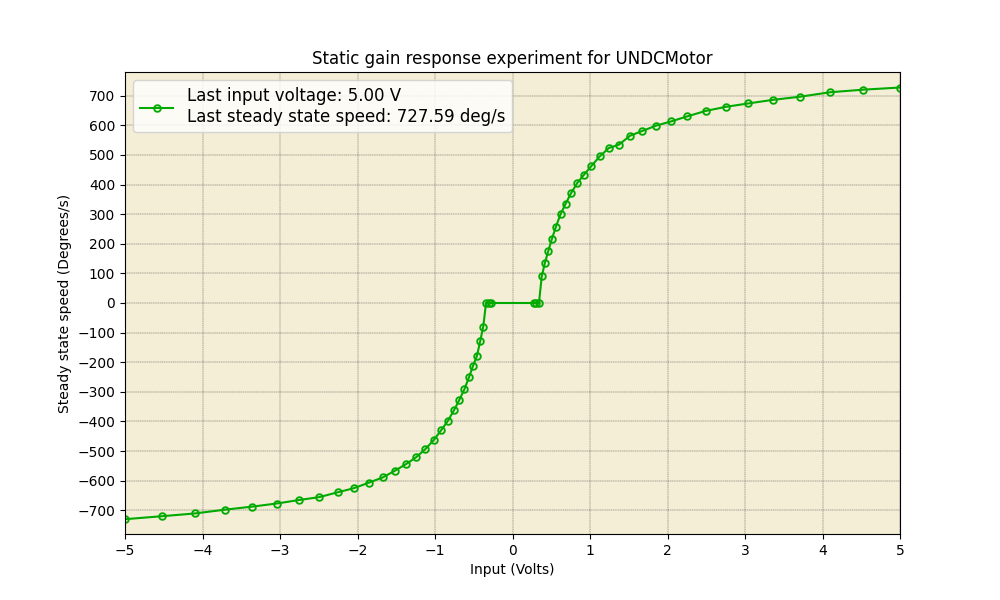

In [8]:
ue, ye = mot.get_static_model(my_motor) 
plt.savefig("static_model.png", format="png", bbox_inches="tight")  
plt.show()

**Note que la salida los valores de estado estacionario de la entrada y la salida quedan registrados en las variables `ue`, `ya`. También quedan guardados en el archivo `\experiment_files\DCmotor_static_gain_response.csv` presente en la carpeta en la que ejecuta este script.**



### Preguntas sobre el modelo estático

Por favor responda las siguientes preguntas sobre el modelo estático en su videoinforme y haga una explicación preliminar muy breve en el documento compartido de la clase de laboratorio

1.  ¿Cuál es la zona muerta del motor?
2.  ¿Para cuales velocidades es muy difícil controlar el motor?
3.  ¿Hasta que velocidad se puede controlar el motor?
4.  Suponga que un modelo aproximado del motor está dado por $G(s)=\frac{\alpha}{\tau\,s+1}$. ¿Cual de los parámetros ($\alpha$ o $\tau$) se ve afectado por la no linealidad de la curva del modelo estático? 

## 4. Modelo dinámico del UNDCMotor

A continuación vamos a obtener el modelo dinámico del UNDCMotor usando dos tipos de experimentos:

1. Modelo por respuesta al escalón
2. Modelo por respuesta a una secuencia binaria pseudoaleatoria.

---

### Modelo por Respuesta al escalón 

Un motor DC puede ser descrito con muy buena aproximaxión por un  [modelo lineal de primer orden](https://github.com/nebisman/UNDCMotor/blob/main/docs/modelo_matematico_unmotor.pdf), si consideramos que la entrada es tensión y la salida es la velocidad angular.

Así, el UNDCMotor puede ser descrito por la siguiente función de transferencia:

$$G(s)= \frac{\alpha}{\tau\, s + 1}$$

Es usual que la primera prueba de identificación de sistemas que parecen de primer orden sea por la respuesta al escalón. 

La función `G = get_fomodel_step(system, yop = desired_op)`  *(get first order model by using step response)* permite obtener la respuesta al escalón y el modelo matemático del UNDCMotor por medio del [método de los 4 puntos](https://github.com/nebisman/UNDCMotor/blob/main/docs/metodo_4_puntos.pdf).

+ El parámetro `system` es la instancia del UNDCMotor creada con la función  `MotorSystemIoT(.)`

+ El parámetro `yop = desired_op` permite obtener la respuesta al escalón con un cambio centrado de tensión que centra aproximadamente los valores final e inicial del escalón en el punto de operación `yop`.

+  La salida `G` retorna la función de transferencia del sistema.

En el ejemplo siguiente obtenemos la respuesta al escalón y el modelo para el punto de operación $y_{OP}=100 ^o/s$.



In [ ]:
G = get_fomodel_step(my_dcmotor, yop = xx)
plt.savefig("first_order_model_yop_100.png", format="png", bbox_inches="tight")
plt.show()


#### Experimento con el modelo por respuesta al escalón

Encuentre los modelos dinámicos por respuesta al escalón para los siguientes puntos de operación:

+ $y_{OP}=50^o/s$
+ $y_{OP}=300^o/s$
+ $y_{OP}=600^o/s$


#### Preguntas sobre el modelo por respuesta al escalón

+ Describa como cambia la constante de tiempo $\tau$ al incrementar la velocidad
+ Describa como cambia la constante de ganancia $\alpha$ al incrementar la velocidad
+ ¿Qué implicaciones puede tener esto en control de velocidad?

---
  


### Modelo por respuesta a una señal binaria pseudoaleatoria (PRBS) 


Una forma de experimento más refinado para obtener el modelo lineal de un sistema en torno de un punto de operación es mediante el uso de **secuencias binarias pseudoaleatorias**. Este tipo de secuencias tienen una mayor riqueza espectral que los simples escalones y, por consiguiente, permiten obtener modelos lineales más refinados de un sistema en torno de un punto de operación.

El UNDCMotor puede ser descrito aproximadamente por  [la siguiente función de transferencia de primer orden](https://github.com/nebisman/UNDCMotor/blob/main/docs/modelo_matematico_unmotor.pdf):

$$G_1(s)= \frac{\alpha}{\tau\, s + 1} \text{ (Ec. 1)}.$$ 

Y, más exactamente, por una [función de transferencia de segundo orden](https://github.com/nebisman/UNDCMotor/blob/main/docs/modelo_matematico_unmotor.pdf) , dada por: 

$$G_2(s)= \frac{\alpha}{(\tau_1\, s + 1)(\tau_2\, s + 1)} \text{ (Ec. 2)}.$$


La función `G1, G2 = get_models_prbs(system, yop = desired_speed)` (*get models by using a PRBS input*) permite obtener la respuesta a una entrada de tipo PRBS y encuentra los modelos de primer y segundo orden que mejor ajustan los datos.

+ El parámetro `system` es la instancia del UNDCMotor creada con la función  `MotorSystemIoT(.)`

+ El parámetro `yop = desired_op` permite obtener el experimento con la entrada PRBS centrada en el punto de operación `yop`

+  Las salidas `G1` y `G2` retornan, respectivamente, las funciones de transferencia de primero y segundo orden del UNDCMotor.

En el ejemplo siguiente obtenemos la respuesta a una entrada PRBS para el punto de operación $y_{OP}=100 ^o/s$.



In [ ]:
G1, G2 = get_models_prbs(my_dcmotor, yop=xx)
plt.savefig("PRBS_models_yop_100.png", format="png", bbox_inches="tight")  
plt.show()


#### Experimentos con la entrada PRBS

Encuentre los modelos dinámicos por por medio de la entrada PRBS para los siguientes puntos de operación:

+ $y_{OP}=100^o/s$
+ $y_{OP}=300^o/s$
+ $y_{OP}=600^o/s$
  


#### Preguntas sobre los modelos con la entrada PRBS

+ Compare los modelos de primer orden con los obtenidos por la respuesta al escalón. ¿Se parecen?
+ Si tiene que diseñar sistemas de control, *¿cuál modelo prefiere: el de primero o el de segundo orden?*
+ Revise el modelo matemático del UNDCMotor. ¿Por qué es un modelo de segundo orden y por qué puede aproximarse por uno de primer orden? Discuta sobre esto.
+ Discuta que es una señal binaria pseudoaleatoria (PRBS) y por qué se usa en identificación de sistemas.  